## Analysing energy changes at sub-global scales

In CMIP5 climate model simulations, drift can lead to substantial non-closure of the global energy budget (i.e. discrepancies between changes in netTOA flux, ocean surface heat flux and ocean heat storage). Foruntately, it has been shown that in most cases this issue can be remedied (i.e. budget closure can be acheived) by dedriting the netTOA, ocean surface heat flux and OHC data ([Hobbs et al 2016](https://journals.ametsoc.org/doi/10.1175/JCLI-D-15-0477.1); [My Anaylsis](https://github.com/DamienIrving/ocean-analysis/blob/master/development/cmip_energy_closure.md)).   

Of course, many analyses are interested in changes to the energy budget at sub-global scales. In general, there are a few different approaches to energy budget analysis at these scales, which I compare and contrast below:
1. Flux integral
2. Linear trend
3. OHC tendency

My hypothesis is that while dedrifting can be helpful at sub-global scales, it typically does not lead to complete budget closure. This can lead to different conclusions/interpretations of model data, depending on the approach used.

(There are also complicating side issues such as regridding of ocean data and data availability.)

In [1]:
import os, sys
import iris
import numpy
import iris.plot as iplt
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context('talk')

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import general_io as gio
import timeseries
import convenient_universal as uconv


### 1. Flux integral approach

On a global scale, the most common approach to analysing changes in the oceanic energy budget is to plot the change in ocean heat content against the cumulative sum of the ocean surface heat flux (i.e. take the temporal integral of the surface flux to get the corresponding change in heat) (e.g. [Hobbs et al 2016](https://journals.ametsoc.org/doi/10.1175/JCLI-D-15-0477.1); [my anaylsis](https://github.com/DamienIrving/ocean-analysis/blob/master/development/cmip_energy_closure.md)). This approach works well, because any non-zero accumulation of ocean surface heat flux (after dedrifting) will be reflected in the (dedrifted) change in OHC, because in a stationary climate the globally integrated ocean surface heat flux will be zero.

The wrinkle in this approach at a sub-global scale is that the ocean surface heat flux isn't necessarily zero in a stationary climate. It is therefore necessary to calculate the stationary climatology (from dedrifted control data) and then calculate the (dedrifted) ocean surface heat flux anomaly timeseries relative to that climatology. You do the same for your ocean heat transport data, and then any non-zero accumulation in the ocean surface heat flux anomaly should be reflected by the sum of the (dedrifted) local change in OHC and the accumulated ocean heat convergence/divergence flux anomaly.

(I think this is essentially the approach that [Frolicher et al (2015)](https://journals.ametsoc.org/doi/abs/10.1175/JCLI-D-14-00117.1) take.)

In [2]:
def calc_anomaly(cube):
    """Calculate the anomaly."""
    
    anomaly = cube.copy()
    anomaly.data = anomaly.data - anomaly.data[0]
    
    return anomaly


def get_data(model):
    """Get the hfds, ohc and hfbasin data"""

    hfds_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/historical/yr/ocean/r1i1p1/hfds/latest/dedrifted/hfds-zonal-sum_Oyr_%s_historical_r1i1p1_cumsum-all.nc' %(model, model)
    ohc_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/historical/yr/ocean/r1i1p1/ohc/latest/dedrifted/ohc-zonal-sum_Oyr_%s_historical_r1i1p1_all.nc' %(model, model)
    hfbasin_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/historical/yr/ocean/r1i1p1/hfbasin/latest/dedrifted/hfbasin-global_Oyr_%s_historical_r1i1p1_cumsum-all.nc' %(model, model)
    
    time_constraint = gio.get_time_constraint(['1861-01-01', '2005-12-31'])
    
    ohc_cube = iris.load_cube(ohc_file, 'ocean heat content' & time_constraint)
    hfds_cube = iris.load_cube(hfds_file, 'surface_downward_heat_flux_in_sea_water' & time_constraint)
    hfbasin_cube = iris.load_cube(hfbasin_file, 'northward_ocean_heat_transport' & time_constraint)
    
    ohc_anomaly = calc_anomaly(ohc_cube)
    hfds_anomaly = calc_anomaly(hfds_cube)
    hfbasin_anomaly = calc_anomaly(hfbasin_cube)
    
    convergence = ohc_anomaly[-1, ::] - hfds_anomaly[-1, ::]
    
    hfbasin = convergence.copy()
    hfbasin.data = numpy.ma.cumsum(-1 * convergence.data)
    
    return ohc_anomaly, hfds_anomaly, hfbasin_anomaly, convergence, hfbasin

In [6]:
ohc_anomaly, hfds_anomaly, hfbasin_anomaly, convergence, hfbasin = get_data('CSIRO-Mk3-6-0')

In [7]:
%matplotlib inline

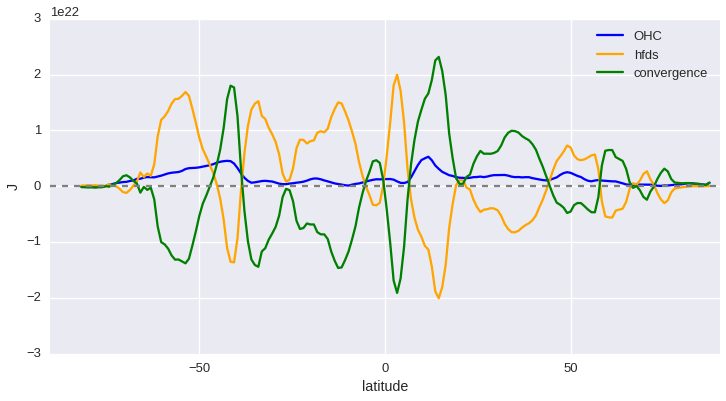

In [8]:
fig, ax = plt.subplots(figsize=[12, 6])

iplt.plot(ohc_anomaly[-1, ::], color='blue', label='OHC')
iplt.plot(hfds_anomaly[-1, ::], color='orange', label='hfds')
iplt.plot(convergence, color='green', label='convergence')

plt.xlabel('latitude')
plt.ylabel('J')
plt.xlim(-90, 90)

plt.axhline(y=0, color='0.5', linestyle='--')

plt.legend()
plt.show()

In [9]:
ohc_anomaly[-1, ::].data.sum()

2.6108229638745892e+23

In [10]:
hfds_anomaly[-1, ::].data.sum()

3.242669292625602e+23

The OHC total matches the [corresponding global timeseries](https://www.flickr.com/photos/69921266@N08/40373452040/). 

The HFDS total does not match the global timeseries. What is plotted is the cumulative sum of the anomaly relative to the dedrifted zonal sum climatology (i.e. the anomaly relative to a stationary climate). 

To be more specific, the steps are:
1. Calculate the zonal sum timeseries for the historical and piControl experiments
2. Dedrift both these timeseries at each latitudinal grid point
3. Calculate the climatology for the dedrifted piControl data. This represents the climatology in a stationary climate.
4. Calculate the cumulative sum of the historical anomaly timeseries (relative to the dedrifted control climatology). This represents the accumulation of anomalous heat and is what is plotted above.


In theory, the global sum of the zonal sum values in the stationary climate climatology should be zero. This isn't the case; the sum is -2.26e+21 J.
* This is possibly consistent with nonlinearities I've observed in other contexts: dedrifting at a series of points and then adding them up does not give the same result as adding all the points up and then dedrifting.
* In the global content I also dedrift the cumulative sum, whereas in this case the dedrifting 

It should also be noted that cumulative sum approach taken here yields a HFDS curve that has a different shape than that obtained by plotting the linear trend in dedrifted historical zonal sum data (again, presumably due to nonlinearities).

These findings might highlight the need for a hemispherically integrated analysis to confirm the zonal sum results (i.e. since energy closure is lost once you start working at sub-global scales - for individual models at least, not sure about the ensemble). 

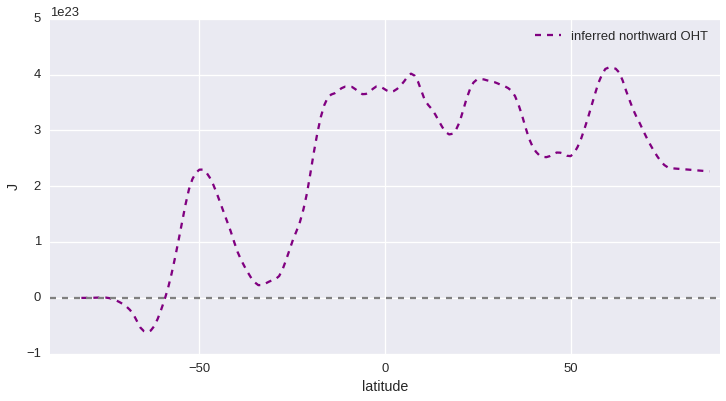

In [87]:
fig, ax = plt.subplots(figsize=[12, 6])

#iplt.plot(hfbasin_anomaly[-1, ::], color='purple', label='northward OHT')
iplt.plot(hfbasin, color='purple', linestyle='--', label='inferred northward OHT')

plt.xlabel('latitude')
plt.ylabel('J')
plt.xlim(-90, 90)

plt.axhline(y=0, color='0.5', linestyle='--')

plt.legend()
plt.show()

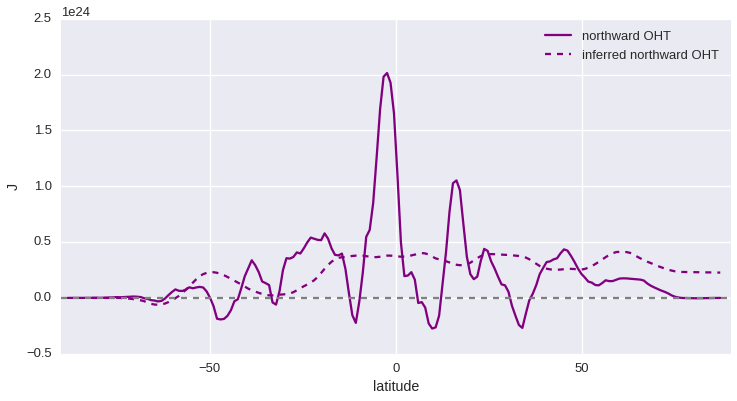

In [88]:
fig, ax = plt.subplots(figsize=[12, 6])

iplt.plot(hfbasin_anomaly[-1, ::], color='purple', label='northward OHT')
iplt.plot(hfbasin, color='purple', linestyle='--', label='inferred northward OHT')

plt.xlabel('latitude')
plt.ylabel('J')
plt.xlim(-90, 90)

plt.axhline(y=0, color='0.5', linestyle='--')

plt.legend()
plt.show()

In [89]:
hfbasin_anomaly[-1, ::].data.sum()

3.8603516768860879e+25

In [90]:
hfbasin.data.sum()

4.1898919017094753e+25

### 2.  Linear trend

This is often the approach taken when looking at a single aspect of the energy budget in isolation (e.g. Shi et al, submitted). My [preliminary results](https://www.authorea.com/users/5641/articles/211791-exploring-the-ocean-response-to-anthropogenic-forcing) are presented as linear trends.

### 3. OHC tendency

This is the approach taken by [Nummelin et al (2017)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1002/2016GL071333). I look at it in some detail [here](https://www.authorea.com/users/5641/articles/176078-replicating-nummelin-et-al-2017/_show_article).